# Big Data in Finance: In-Class Presentation

In [7]:
import time
import pandas as pd
import datetime as dt
import helper_functs as hf
import warnings
import copy
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Loading Dataset

In [8]:
tickers = pd.read_excel("data_sources/PERMNO_Tickers.xlsx", index_col="Dates")
tickers.index = pd.to_datetime(tickers.index,  format='%Y%m%d').date
tickers.name = "TICKERS"

flows = pd.read_excel("data_sources/Flows_Clean.xlsx", index_col="Dates")
flows.index = pd.to_datetime(flows.index, format='%Y%m%d').date
flows.name = "FLOWS"

returns = pd.read_excel("data_sources/Returns_Clean.xlsx", index_col="Dates")
returns.index = pd.to_datetime(returns.index,format='%Y%m%d').date
returns.name = "RETURNS"

In [9]:
tickers.head()

,PERMNO,TICKER,COMNAM
1993-04-01,10145,ALD,ALLIED SIGNAL INC
1993-04-02,10145,ALD,ALLIED SIGNAL INC
1993-04-05,10145,ALD,ALLIED SIGNAL INC
1993-04-06,10145,ALD,ALLIED SIGNAL INC
1993-04-07,10145,ALD,ALLIED SIGNAL INC


In [10]:
flows.head()

,55976,41072,27748,75259,40970,62519,21792,54084,55511,10302,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
1993-04-01,-4.696503,-23.581608,0.904076,1.960112,0.687935,-1.791999,-1.465184,-0.124006,-1.681277,-3.439391,...,-3.762768,-1.733699,1.126364,-7.138398,3.073116,1.617669,2.448601,3.493056,0.902557,-0.535050
1993-04-02,-6.975709,-23.331232,0.394204,23.691814,-1.895012,0.551048,-1.488078,-0.170873,-1.588607,-4.584278,...,-0.419981,-2.612104,0.019097,-7.138398,2.033127,-2.418096,-1.523983,-9.594576,-10.226385,-0.274176
1993-04-05,-5.642141,-19.851716,-1.597132,8.839406,0.475161,8.010732,0.298018,0.281993,1.024464,7.026194,...,-0.474352,1.625321,1.149879,-6.056788,2.309195,4.493038,0.854999,2.615968,0.817579,1.478560
1993-04-06,-6.975709,23.276153,-1.129123,14.299749,1.426277,9.120669,-0.317257,-0.059609,5.883830,-0.598776,...,-1.294707,1.255646,0.803975,-2.927825,-5.331582,1.635919,-9.876419,-2.862576,-3.755393,1.674835
1993-04-07,-6.975709,19.204137,-1.221991,-5.184144,-1.638974,0.808131,-0.463507,0.610452,-1.209499,2.164043,...,0.000000,8.642735,1.060310,-2.069588,-1.625845,2.295149,0.570760,5.847429,-1.580178,1.814051


# Warm-Up

In [11]:
PERMNO = list(returns.columns) #PERMNO is the same everywhere, i.e. tickers, flows, returns
WINDOW_SIZE = 255

### Rolling MA Benchmark

In [12]:
all_stocks =pd.DataFrame(index=returns.index)
all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] = 0
SMA_cumulative_RMSE_per_stock= {}
for number in PERMNO:
    stock = hf.create_stock_df(number,[flows, returns,tickers])
    stock_lagged = hf.get_lags(stock, 3).dropna()
    stock_X, stock_Y = hf.x_y_split(stock_lagged)
    stock_SMA = copy.deepcopy(stock_Y)
    stock_SMA.columns = [f'{number}_RETURNS' if x=='RETURNS' else x for x in stock_SMA.columns]
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]=stock_SMA[f'{number}_RETURNS'].rolling(WINDOW_SIZE).mean().shift(1)
    stock_SMA = stock_SMA.dropna()    
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"]=(stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]-stock_SMA[f'{number}_RETURNS'])**2
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"] = stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] += stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"]
    SMA_cumulative_RMSE_per_stock[number]= stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"].sum()
    all_stocks[stock_SMA.columns]= stock_SMA

<AxesSubplot:>

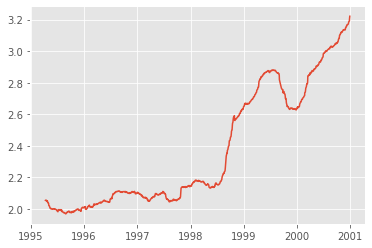

In [13]:
all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"].plot()

### Rolling Regression

In [15]:
all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] = 0
test_list = PERMNO[:2]
start = time.time()
for i,number in enumerate(test_list):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_LM = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.LinearRegression(),progession_param=0.2)
    stock_LM.columns = [f'{number}_{WINDOW_SIZE}_LM_{x}' for x in stock_LM.columns]
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"] = (stock_LM[f"{number}_{WINDOW_SIZE}_LM_PRED"]-stock_LM[f'{number}_{WINDOW_SIZE}_LM_RETURNS'])**2
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"] = stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] += stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"]
    all_stocks[stock_LM.columns]= stock_LM
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

In [ ]:
all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"].plot()

### Rolling LASSO

In [ ]:
hyperparameters_LASSO = {'alpha': [1,0.1, 0.01]}

In [ ]:
all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
PERM= PERMNO
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_LASSO = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.Lasso(alpha=0.01),progession_param=0.2)
    stock_LASSO.columns = [f'{number}_{WINDOW_SIZE}_LASSO_{x}' for x in stock_LASSO.columns]
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"] = (stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_PRED"]-stock_LASSO[f'{number}_{WINDOW_SIZE}_LASSO_RETURNS'])**2
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"] = stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE)**0.5
    all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] += stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"]
    all_stocks[stock_LASSO.columns]= stock_LASSO
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

In [ ]:
all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    stock_RF = hf.Rolling_ML(WINDOW_SIZE, x_full, ,progession_param=0.2)
    stock_RF.columns = [f'{number}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{number}_{WINDOW_SIZE}_RF_RETURNS'])**2
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] += stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"]
    all_stocks[stock_RF.columns]= stock_RF
    end = time.time()
    if (i+1) % 5 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")